In [5]:
# https://github.com/poldrack/infomap_sims/blob/main/infomap_sims.py
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.16.4
#   kernelspec:
#     display_name: .venv
#     language: python
#     name: python3
# ---

# %%
import scipy.io
import numpy as np
import pandas as pd
from infomap import Infomap
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import networkx as nx


# utility functions
def r_to_z(r):
    # if it's not a numpy array, make it one
    if not isinstance(r, np.ndarray):
        r = np.array([r])
    # fisher transform
    r = np.clip(r, -0.999999, 0.999999)
    z = 0.5 * np.log((1.0 + r) / (1.0 - r))
    z[np.where(np.isinf(z))] = 0
    z[np.where(np.isnan(z))] = 0

    return z


def z_to_r(z):
    # inverse transform
    return (np.exp(2.0 * z) - 1) / (np.exp(2.0 * z) + 1)


# functions for simulation
def load_priors(infile="./debug/Russ Poldrack/infomap_sims/priors.mat", size_ratio=2):
    mat = scipy.io.loadmat(infile)

    # limit size for computational reasons - only use 1/size_ratio of data
    sizelimit = int(mat["Priors"][0][0][0].shape[0] / size_ratio)

    fcpriors = mat["Priors"][0][0][0][:sizelimit]
    spatialpriors = mat["Priors"][0][0][1][:sizelimit]
    names = [str(i[0][0]) for i in mat["Priors"][0][0][2]]
    return mat, fcpriors, spatialpriors, names


def get_maxprob_labels(priors):
    return np.argmax(priors, axis=1).astype(int)


def matching_matrix_to_graph(matching_matrix, density=0.05):
    G = nx.Graph()
    G.add_nodes_from(range(matching_matrix.shape[0]))
    thresh = np.percentile(matching_matrix, 100 * (1 - density))
    match_pairs = np.where(matching_matrix >= thresh)
    match_pairs_clean = [
        (int(i), int(j)) for i, j in zip(match_pairs[0], match_pairs[1]) if i != j
    ]
    G.add_edges_from(match_pairs_clean)
    return G


def get_matching_matrix(maxprob_fc):
    matching_matrix = (maxprob_fc[:, None] == maxprob_fc).astype(np.float32)
    # set diagonal to zero
    np.fill_diagonal(matching_matrix, 0)

    # create a z-scored version for use in generating noisy versions
    matching_matrix_z = r_to_z(matching_matrix)

    return matching_matrix, matching_matrix_z


def get_match_pairs(matching_matrix, thresh=0.99):
    match_pairs = np.where(matching_matrix >= thresh)
    match_pairs_clean = [
        (int(i), int(j)) for i, j in zip(match_pairs[0], match_pairs[1]) if i != j
    ]
    return match_pairs_clean

# EDIT: Changed fcpriors parameter to true_labels as that's the only extra data needed
def run_infomap(G, true_labels, verbose=False):
    im = Infomap(silent=True)

    _ = im.add_networkx_graph(G)
    im.run()
    if verbose:
        print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    module_id_dict = {node.node_id: node.module_id for node in im.tree if node.is_leaf}
    module_list = np.array([module_id_dict[i] for i in range(true_labels.shape[0])])
    #true_labels = get_maxprob_labels(fcpriors)
    cm = confusion_matrix(true_labels, module_list)

    # relabel modules to match true labels
    cm_argmax = cm.argmax(axis=0)
    module_list_relabeled = np.array([cm_argmax[i] for i in module_list])

    return module_list, module_list_relabeled


def create_noisy_matching_matrix(
    matching_matrix_z, noise_level=1, cutoff=0.6, seed=None
):
    rng = np.random.default_rng(seed)
    # EDIT: Replaced matching_matrix with matching_matrix_z
    noise = rng.normal(0, noise_level, matching_matrix_z.shape)
    cutoff_z = r_to_z(cutoff)[0]
    matching_matrix_z_noisy = (
        np.clip(matching_matrix_z, -1 * cutoff_z, cutoff_z) + noise
    )
    matching_matrix_noisy = z_to_r(matching_matrix_z_noisy)
    return matching_matrix_noisy


def get_module_counts(module_list, true_labels):
    modules = sorted(np.unique(true_labels).tolist())
    counter = {i: int(np.sum(module_list == i)) for i in modules}
    return counter



In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
%config InlineBackend.figure_format='retina'

In [8]:
scipy.io.loadmat("./debug/Russ Poldrack/infomap_sims/priors.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed May  1 14:10:53 2024',
 '__version__': '1.0',
 '__globals__': [],
 'Priors': array([[(array([[ 0.3157841 ,  0.20616231,  0.19917327, ..., -0.07799404,
                 -0.11810973, -0.12997715],
                [-0.05145701, -0.06754163, -0.11364691, ...,  0.34099037,
                  0.17351865,  0.27756615],
                [-0.0533896 , -0.03064595, -0.10834466, ...,  0.15181324,
                  0.11279641,  0.23672836],
                ...,
                [ 0.07512631,  0.05822083,  0.24023739, ..., -0.09027877,
                 -0.08626452, -0.13439889],
                [ 0.09607944,  0.09172736,  0.2470739 , ..., -0.08800698,
                 -0.08646766, -0.13536839],
                [ 0.07597794,  0.05547568,  0.23457405, ..., -0.08390644,
                 -0.08477971, -0.13037432]]), array([[0.8       , 0.        , 0.06666667, ..., 0.        , 0.        ,
                 0.        ],
                

In [61]:
nruns = 100
size_ratio = 2
mat, fcpriors, spatialpriors, names = load_priors(size_ratio=size_ratio)

# we just use functional connectivity priors from WashU team
# to create ground truth for this simulation
maxprob_fc = get_maxprob_labels(fcpriors)

fcpriors, fcpriors.shape, maxprob_fc, maxprob_fc.shape

(array([[ 0.316,  0.206,  0.199, ..., -0.078, -0.118, -0.13 ],
        [-0.051, -0.068, -0.114, ...,  0.341,  0.174,  0.278],
        [-0.053, -0.031, -0.108, ...,  0.152,  0.113,  0.237],
        ...,
        [-0.061, -0.059, -0.132, ...,  0.013,  0.067,  0.042],
        [ 0.062,  0.022,  0.218, ..., -0.077, -0.089, -0.126],
        [-0.038, -0.062, -0.107, ...,  0.294,  0.249,  0.291]]),
 (29706, 20),
 array([ 0, 17, 16, ...,  4,  2, 17]),
 (29706,))

## Use toy data for testing

In [62]:
maxprob_fc = np.array([0,0,0,1,1,2])

In [64]:
matching_matrix, matching_matrix_z = get_matching_matrix(maxprob_fc)
matching_matrix, matching_matrix_z

(array([[0., 1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0.   , 7.248, 7.248, 0.   , 0.   , 0.   ],
        [7.248, 0.   , 7.248, 0.   , 0.   , 0.   ],
        [7.248, 7.248, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 7.248, 0.   ],
        [0.   , 0.   , 0.   , 7.248, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32))

In [66]:
noise_levels = np.arange(0.05, 0.4, 0.1)

In [70]:
print('running simulations')
results = []

for noise_level in np.arange(0.05, 0.4, 0.1):
    # print("Noise level:", noise_level)
    for run in range(nruns):
        # print(f"Run {run}\r")
        matching_matrix_noisy = create_noisy_matching_matrix(
            matching_matrix_z, noise_level=noise_level
        )
        G = matching_matrix_to_graph(matching_matrix_noisy, density=0.05)
        # EDIT: Changed the fcpriors parameter in run_infomap to true_labels
        module_list, module_list_relabeled = run_infomap(G, true_labels=maxprob_fc, verbose=False)
        ari = adjusted_rand_score(maxprob_fc, module_list)
        results.append(
            [noise_level, ari]
            + list(get_module_counts(module_list_relabeled, maxprob_fc).values())
        )
        # print(f"Noise level: {noise_level}, ARI: {ari}")

results_df = pd.DataFrame(
    results,
    columns=["noise_level", "ari"]
    + [
        f"size_mod{i}"
        for i in list(get_module_counts(module_list_relabeled, maxprob_fc).keys())
    ],
)
# results_df.to_csv("debug/Russ Poldrack/results.csv")
df = results_df
df

running simulations


,noise_level,ari,size_mod0,size_mod1,size_mod2
0,0.05,0.594595,3,2,1
1,0.05,0.594595,3,2,1
2,0.05,0.814815,3,2,1
3,0.05,0.814815,3,2,1
4,0.05,0.328358,3,2,1
...,...,...,...,...,...
395,0.35,0.594595,3,2,1
396,0.35,0.328358,3,2,1
397,0.35,0.814815,3,2,1
398,0.35,0.814815,3,2,1


In [71]:
df_ari = df[['noise_level', 'ari']]
del df['ari']
# rename module sizes
df.columns = [i.replace('size_', '') for i in df.columns]
df.head()

,noise_level,mod0,mod1,mod2
0,0.05,3,2,1
1,0.05,3,2,1
2,0.05,3,2,1
3,0.05,3,2,1
4,0.05,3,2,1


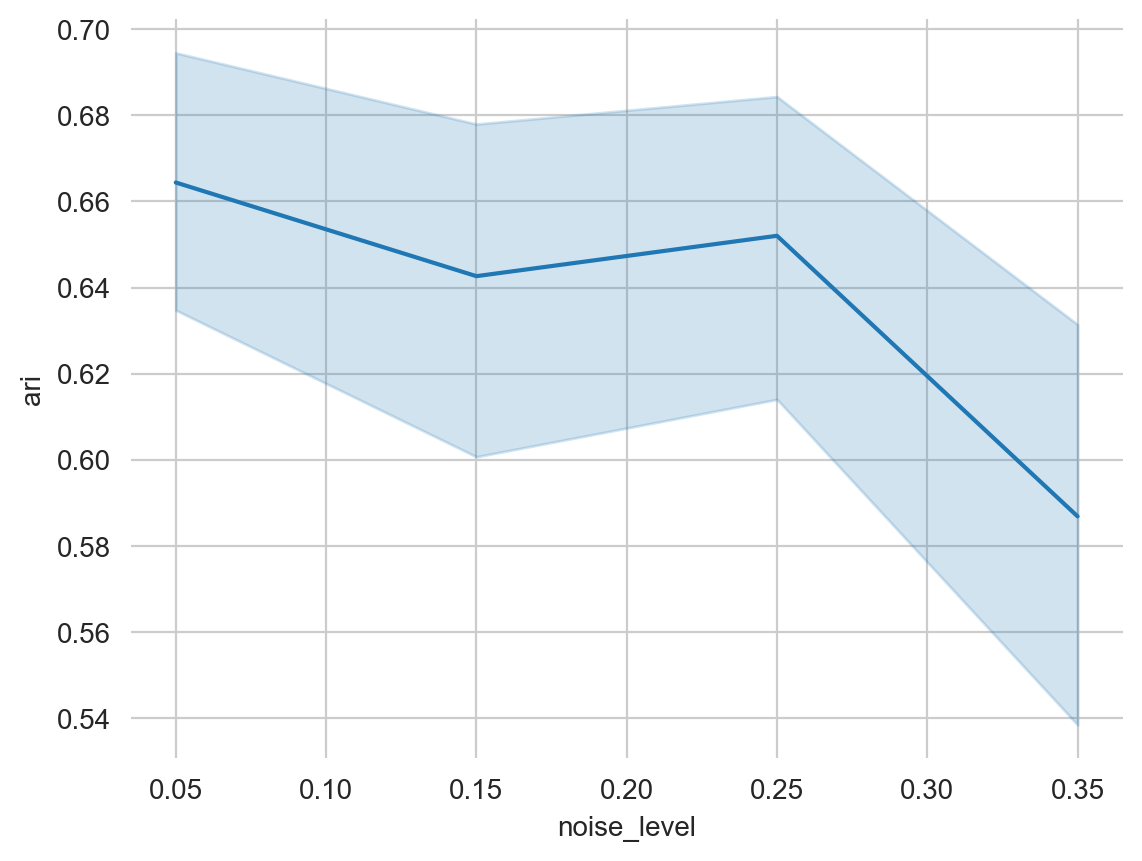

In [73]:
sns.lineplot(df_ari, x="noise_level", y="ari");

In [77]:
# convert from wide to long
df_long = pd.melt(df, id_vars=['noise_level'], var_name='module', value_name='size').query('noise_level < .5')
df_long

,noise_level,module,size
0,0.05,mod0,3
1,0.05,mod0,3
2,0.05,mod0,3
3,0.05,mod0,3
4,0.05,mod0,3
...,...,...,...
1195,0.35,mod2,1
1196,0.35,mod2,1
1197,0.35,mod2,1
1198,0.35,mod2,1


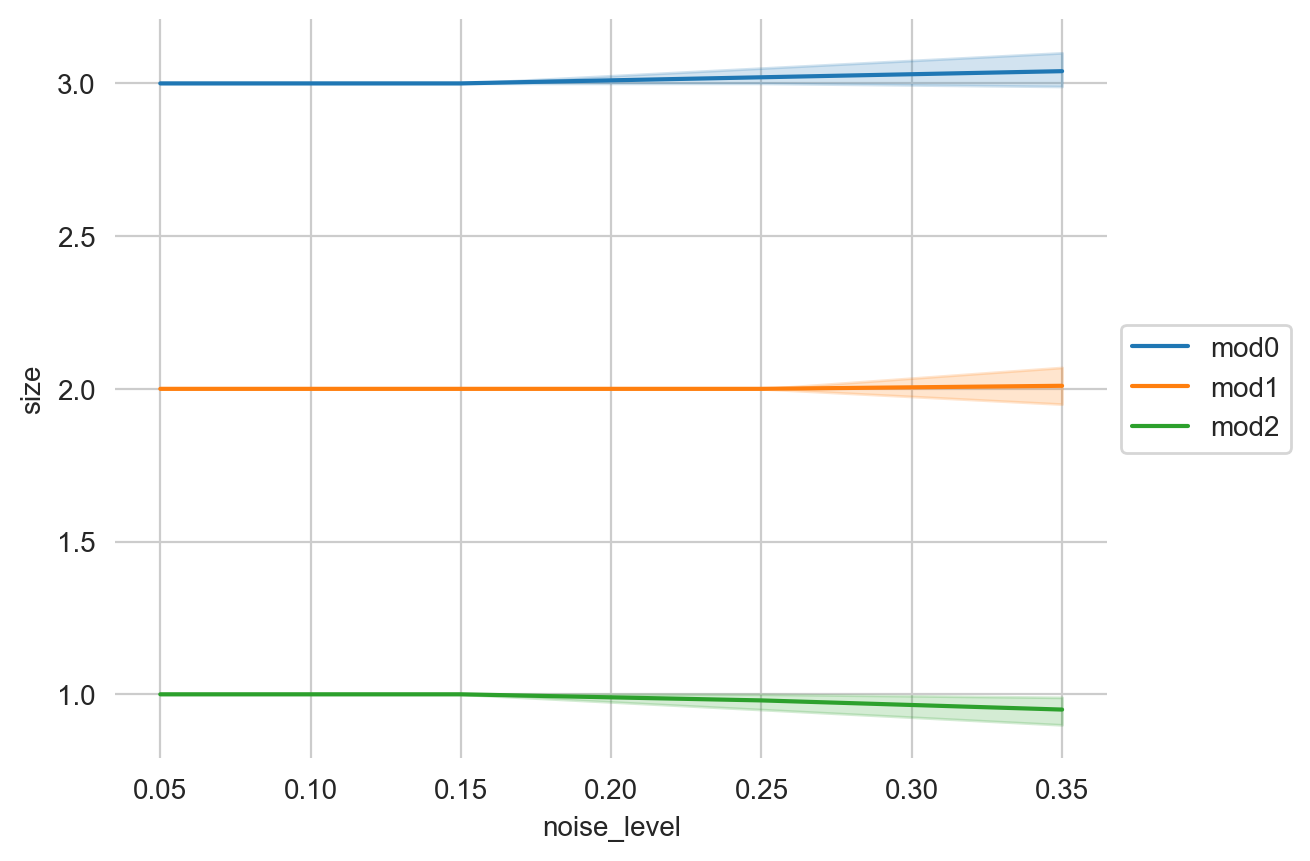

In [78]:
sns.lineplot(x='noise_level', y='size', hue='module', data=df_long)
# put the legend to the right, outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [84]:
matching_matrix = (maxprob_fc[:, None] == maxprob_fc).astype(np.float32)
matching_matrix

array([[1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

The above operation is creates a graph where each node is connected to the nodes with same module label. It is invariant to relabeling.

In [87]:
# Remove self-links
np.fill_diagonal(matching_matrix, 0)

In [86]:
matching_matrix

array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [88]:
# create a z-scored version for use in generating noisy versions
matching_matrix_z = r_to_z(matching_matrix)
matching_matrix_z

array([[0.   , 7.248, 7.248, 0.   , 0.   , 0.   ],
       [7.248, 0.   , 7.248, 0.   , 0.   , 0.   ],
       [7.248, 7.248, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 7.248, 0.   ],
       [0.   , 0.   , 0.   , 7.248, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [91]:
r = 1
r = np.clip(r, -0.999999, 0.999999)
0.5 * np.log((1.0 + r) / (1.0 - r))

7.254328619247669

In [93]:
r = 0.999
0.5 * np.log((1.0 + r) / (1.0 - r))

3.8002011672502

In [95]:
r = 0.99999999
0.5 * np.log((1.0 + r) / (1.0 - r))

9.556913957243776

In [98]:
matching_matrix_noisy = create_noisy_matching_matrix(matching_matrix_z, noise_level=0.35, seed=0)
matching_matrix_noisy

array([[ 0.044,  0.57 ,  0.725,  0.037, -0.185,  0.126],
       [ 0.818,  0.32 ,  0.419, -0.416, -0.215,  0.014],
       [-0.12 ,  0.549, -0.41 , -0.251, -0.188, -0.11 ],
       [ 0.143,  0.35 , -0.045,  0.445,  0.43 ,  0.122],
       [ 0.306,  0.033, -0.255,  0.354, -0.159,  0.077],
       [-0.339, -0.073, -0.056,  0.187,  0.075,  0.124]])

This clips the z matrix with a symmetrical cutoff and adds noise after:

In [100]:
noise_level=0.35
cutoff=0.6
seed=0
rng = np.random.default_rng(seed)
noise = rng.normal(0, noise_level, matching_matrix_z.shape)
cutoff_z = r_to_z(cutoff)[0]
matching_matrix_z_noisy = (
    np.clip(matching_matrix_z, -1 * cutoff_z, cutoff_z) + noise
)
matching_matrix_noisy = z_to_r(matching_matrix_z_noisy)

cutoff_z, matching_matrix_z_noisy, matching_matrix_noisy

(0.6931471805599453,
 array([[ 0.044,  0.647,  0.917,  0.037, -0.187,  0.127],
        [ 1.15 ,  0.331,  0.447, -0.443, -0.218,  0.014],
        [-0.121,  0.617, -0.436, -0.256, -0.19 , -0.111],
        [ 0.144,  0.365, -0.045,  0.478,  0.46 ,  0.123],
        [ 0.316,  0.033, -0.26 ,  0.371, -0.16 ,  0.077],
        [-0.353, -0.073, -0.056,  0.189,  0.075,  0.124]]),
 array([[ 0.044,  0.57 ,  0.725,  0.037, -0.185,  0.126],
        [ 0.818,  0.32 ,  0.419, -0.416, -0.215,  0.014],
        [-0.12 ,  0.549, -0.41 , -0.251, -0.188, -0.11 ],
        [ 0.143,  0.35 , -0.045,  0.445,  0.43 ,  0.122],
        [ 0.306,  0.033, -0.255,  0.354, -0.159,  0.077],
        [-0.339, -0.073, -0.056,  0.187,  0.075,  0.124]]))

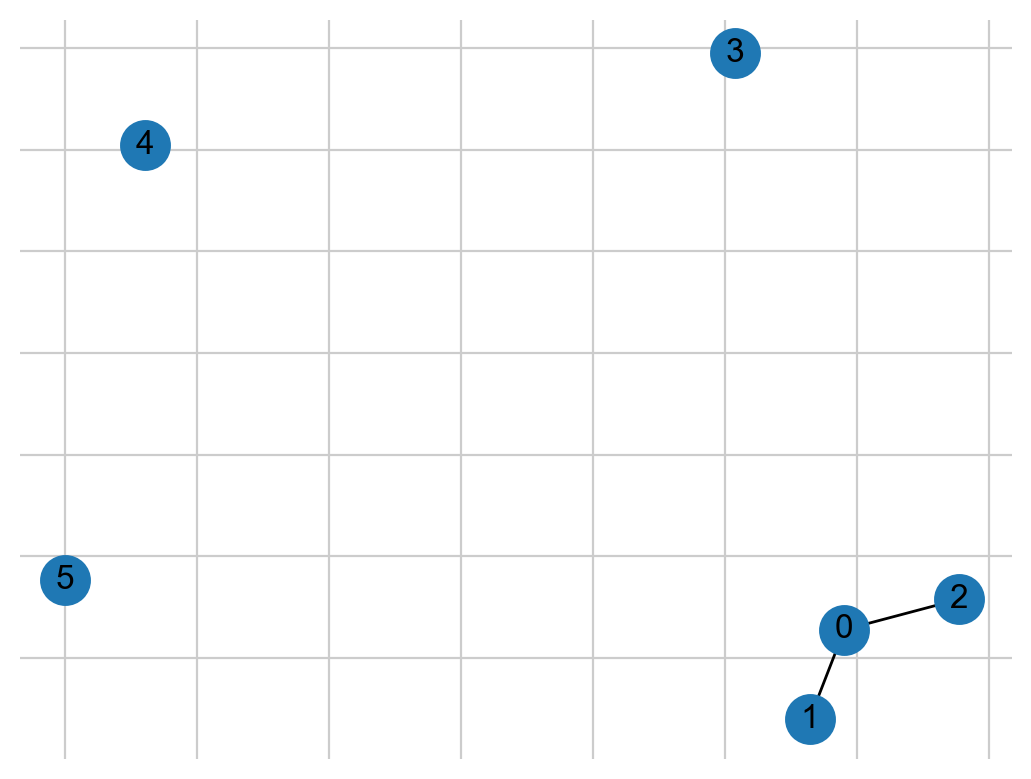

In [112]:
G = matching_matrix_to_graph(matching_matrix_noisy, density=0.05)

nx.draw_networkx(G)

The `matching_matrix_to_graph` function thresholds the noisy matrix from one side and removes all negative links. Below with increased density to recover the prior in the toy data.

(0.354466840733899,
 array([[False,  True,  True, False, False, False],
        [ True, False,  True, False, False, False],
        [False,  True, False, False, False, False],
        [False, False, False,  True,  True, False],
        [False, False, False,  True, False, False],
        [False, False, False, False, False, False]]),
 (array([0, 0, 1, 1, 2, 3, 3, 4]), array([1, 2, 0, 2, 1, 3, 4, 3])))

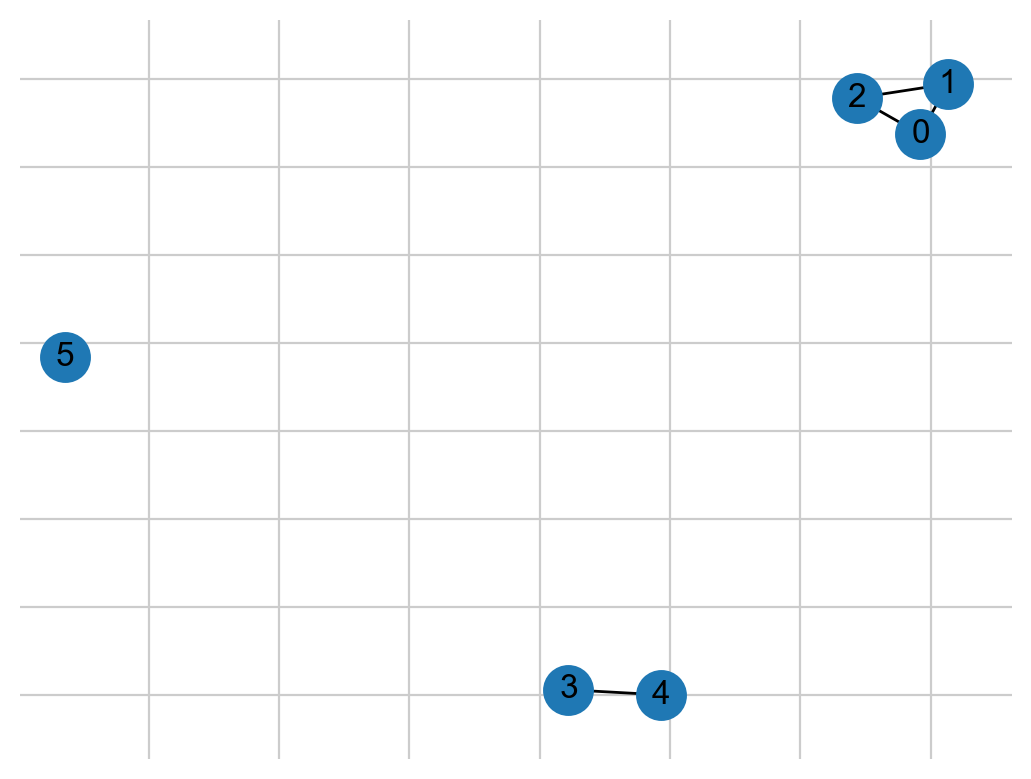

In [116]:
density = 0.2
G = nx.Graph()
G.add_nodes_from(range(matching_matrix_noisy.shape[0]))
thresh = np.percentile(matching_matrix_noisy, 100 * (1 - density))
match_pairs = np.where(matching_matrix_noisy >= thresh)
# Remove potential self-links
match_pairs_clean = [
    (int(i), int(j)) for i, j in zip(match_pairs[0], match_pairs[1]) if i != j
]
G.add_edges_from(match_pairs_clean)

nx.draw_networkx(G)
thresh, matching_matrix_noisy >= thresh, np.where(matching_matrix_noisy >= thresh)

In [117]:
module_list, module_list_relabeled = run_infomap(G, maxprob_fc, verbose=False)
module_list, module_list_relabeled

(array([1, 1, 1, 2, 2, 3]), array([0, 0, 0, 1, 1, 2]))

The `run_infomap` code matches and relabels the detected modules with the planted using the confusion matrix.

In [118]:
im = Infomap(silent=True)

_ = im.add_networkx_graph(G)
im.run()
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

module_id_dict = {node.node_id: node.module_id for node in im.tree if node.is_leaf}
module_list = np.array([module_id_dict[i] for i in range(maxprob_fc.shape[0])])

Found 3 modules with codelength: 1.438721875540867


In [19]:
module_list

array([1, 1, 1, 2, 2, 3])

In [120]:
cm = confusion_matrix(maxprob_fc, module_list)

# relabel modules to match true labels
cm_argmax = cm.argmax(axis=0)
module_list_relabeled = np.array([cm_argmax[i] for i in module_list])

cm, cm_argmax, module_list_relabeled

(array([[0, 3, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]]),
 array([0, 0, 1, 2]),
 array([0, 0, 0, 1, 1, 2]))

## Biases using argmax on the confusion matrix
The confusion matrix counts for each cell `i,j` the number of nodes from the 'true' module `i` that ended up in the 'predicted' module `j`.

The larger the module `i`, the more counts to spread on the ith row, and hence larger probability for row `i` to be argmax across the axis of predicted labels. This creates a bias for large modules that may explain the results.

Another potential bias with `argmax` is an order preference as it picks the first module of the potential many with same maximum count:

In [ ]:
cm = np.array([[1,0,0],[2,1,0],[3,1,0]])
cm, cm.argmax(axis=0)

(array([[1, 0, 0],
        [2, 1, 0],
        [3, 1, 0]]),
 array([2, 1, 0]))

### Test if the diverging module size pattern is an artefact from using argmax on the confusion matrix for module matching

Skip the clustering part and create predicted labels by randomizing the true labels with a certain noise level.

In [26]:
cm = pd.DataFrame(confusion_matrix([0,0,1,1,1,2,2,2,2,2], [5,0,0,0,1,2,2,3,3,4]))
cm

,0,1,2,3,4,5
0,1,0,0,0,0,1
1,2,1,0,0,0,0
2,0,0,2,2,1,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0


<Axes: >

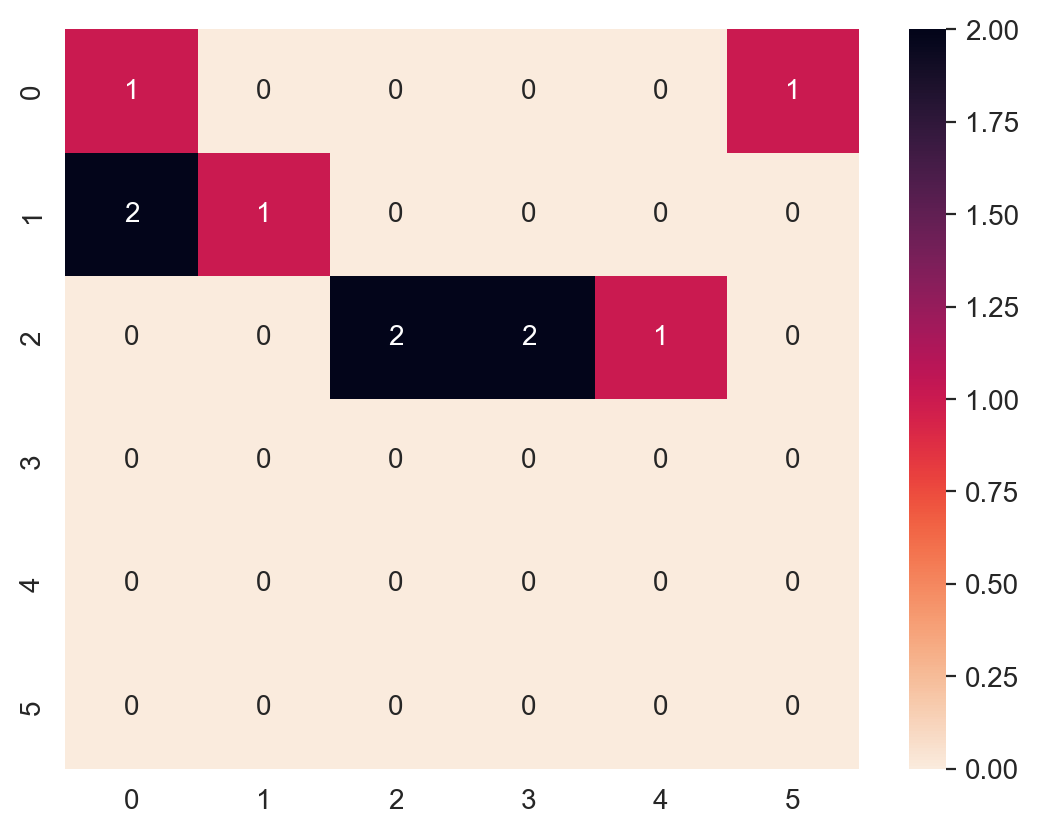

In [28]:
sns.heatmap(cm, annot=True, cmap="rocket_r")

In [29]:
cm_argmax = cm.values.argmax(axis=0)
cm_argmax

array([1, 1, 2, 2, 2, 0])

In [130]:
rng = np.random.default_rng(seed=0)

def sample_multinomial(n, k):
    """Add ``n`` coins in ``k`` bins with uniform probability mass function."""
    return rng.multinomial(n, pvals=np.array([1 / k] * k))

sample_multinomial(10, 4)

array([3, 2, 1, 4])

In [136]:
ind = np.random.choice(10, 4, replace=False)
ind

array([8, 9, 5, 7])

In [155]:
m_true = np.array([0,0,0,1,1,2,2,3,3,4])
ind = np.array([6,2,7,3,9])
ind2 = (m_true[ind] < 3).nonzero()[0]
ind, m_true[ind], m_true[ind] < 3, ind2, ind[ind2], m_true[ind[ind2]]

(array([6, 2, 7, 3, 9]),
 array([2, 0, 3, 1, 4]),
 array([ True,  True, False,  True, False]),
 array([0, 1, 3]),
 array([6, 2, 3]),
 array([2, 0, 1]))

Ground truth: 158 nodes and 6 modules
Matched modules: [5 5 5 3 4 5 4 5 3 5]


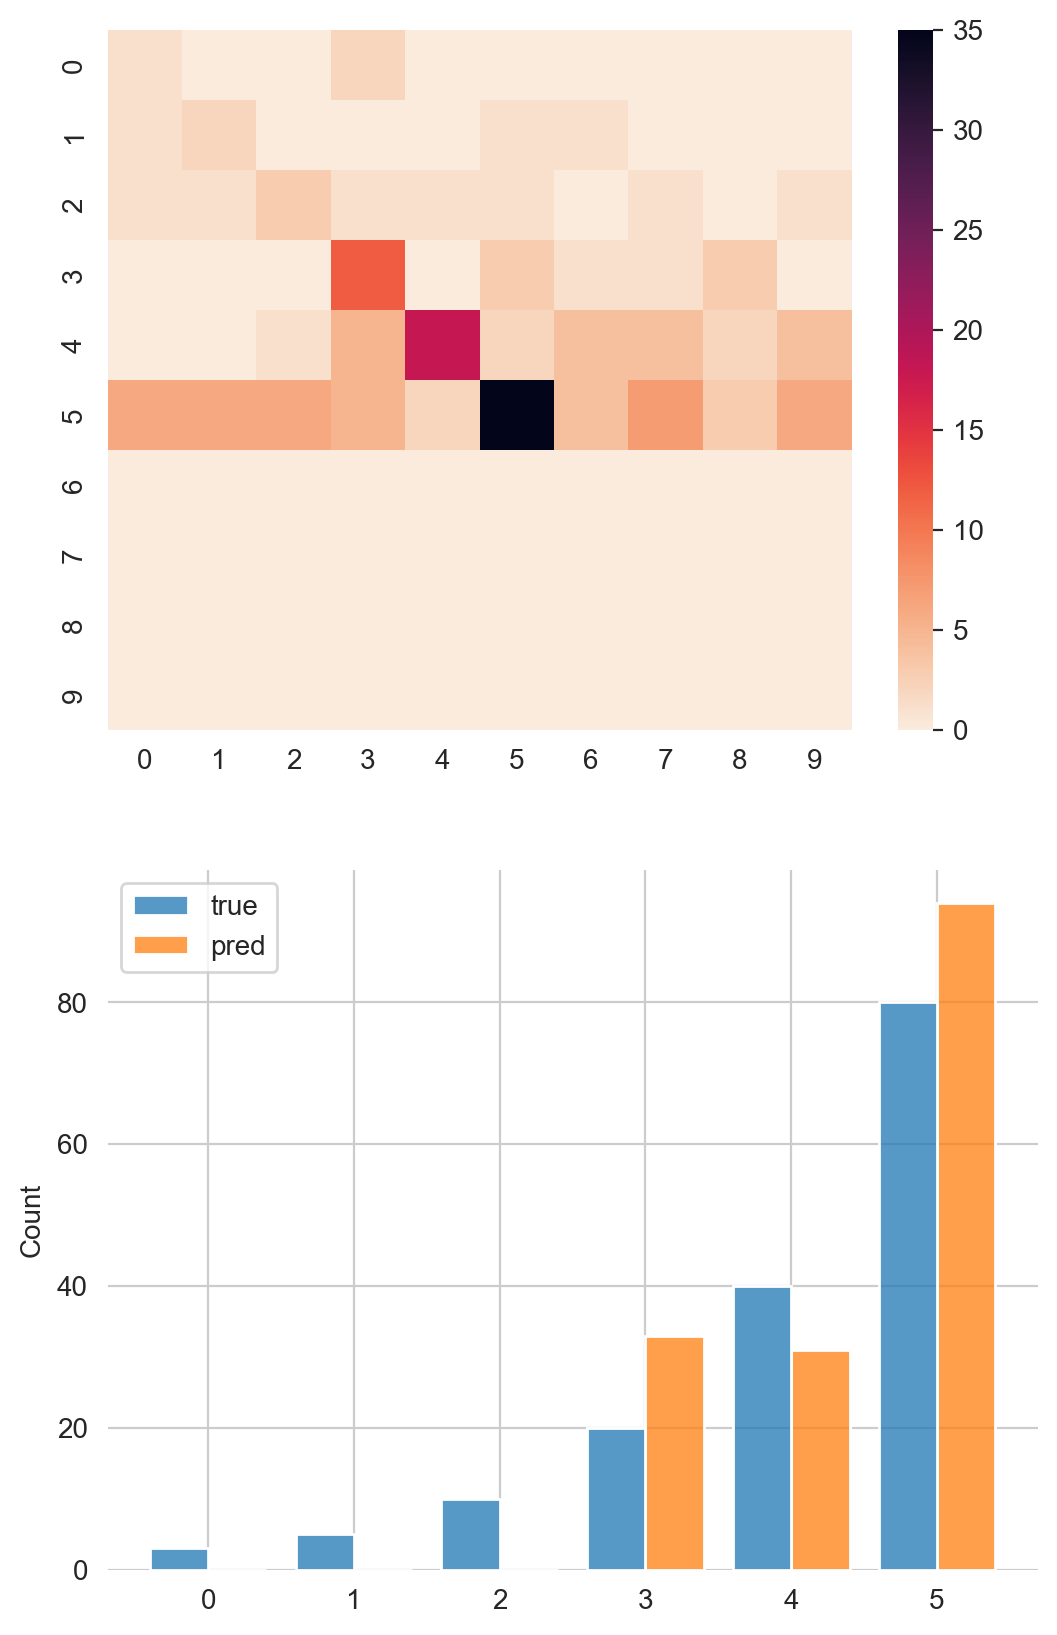

In [193]:
def generate_matching(normalize=False, module_sizes=[3, 5, 10, 20, 40, 80], M_pred=10):
    M_true = len(module_sizes)
    m_true = np.array([lbl for i, m in enumerate(module_sizes) for lbl in [i] * m])
    N = len(m_true)
    print(f"Ground truth: {N} nodes and {M_true} modules")

    # Sample predicted modules with uniformly varying sizes
    module_sizes_pred = sample_multinomial(N, M_pred)
    m_rand = [lbl for i, m in enumerate(module_sizes_pred) for lbl in [i] * m]
    np.random.shuffle(m_rand)

    # Select a proportion of nodes to get correct predicted module
    p_true = 0.4
    ind_true = np.random.choice(N, int(p_true * N), replace=False)
    # Restrict to not create more modules than M_pred
    ind_true = ind_true[(m_true[ind_true] < M_pred).nonzero()[0]]
    m_pred = np.array(m_rand).copy()
    m_pred[ind_true] = m_true[ind_true]
    # reindex to consecutive labels
    m_unique = np.unique(m_pred)
    relabel = dict(zip(m_unique, np.arange(m_unique.shape[0])))
    m_pred = np.array([relabel[m] for m in m_pred])

    cm = confusion_matrix(m_true, m_pred)

    if normalize:
        norm = np.ones(cm.shape[0])
        for i, m in enumerate(module_sizes):
            norm[i] = m
        cm = cm / np.outer(norm, np.ones(norm.shape))

    # relabel modules to match true labels
    cm_argmax = cm.argmax(axis=0)
    m_pred_matched = np.array([cm_argmax[i] for i in m_pred])
    return cm, cm_argmax, m_true, m_pred_matched

cm, cm_argmax, m_true, m_pred_matched = generate_matching()
print("Matched modules:", cm_argmax)
fig, axes = plt.subplots(nrows=2, figsize=(6,10))
sns.heatmap(cm, cmap="rocket_r", ax=axes[0])
ax = sns.histplot(pd.DataFrame({"true": m_true, "pred": m_pred_matched}), multiple="dodge", ax=axes[1], binwidth=1, shrink=0.8, discrete=True)

### The diverging pattern recovered
There is currently a preferential attachment to large modules as argmax on the confusion matrix moves all nodes in a predicted module to the true module that has most of those nodes assigned to it. This seems to explain the bias.

### Normalizing the confusion matrix leads to a converging pattern

We can instead for example match a predicted module with the true module where the nodes makes up the highest proportion. To do this, we can simply divide the rows in the confusion matrix by the size of the corresponding true module.

Ground truth: 158 nodes and 6 modules
Matched modules: [0 1 2 3 4 5 4 2 1 0]


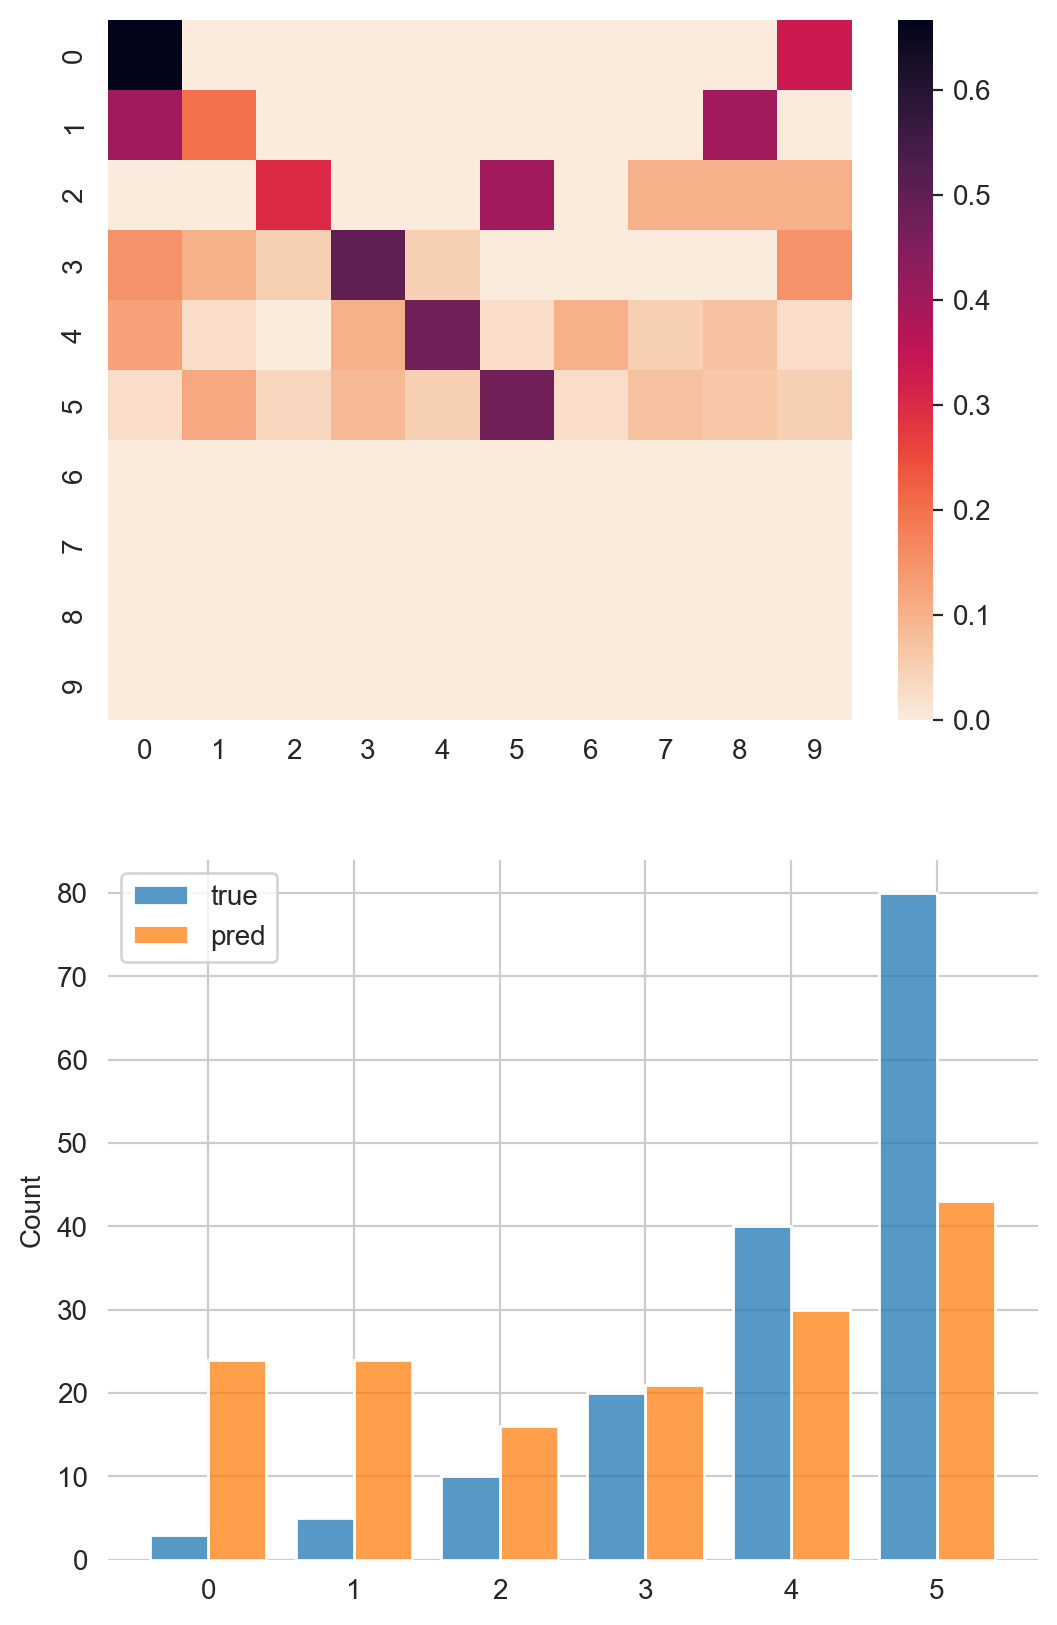

In [194]:
cm, cm_argmax, m_true, m_pred_matched = generate_matching(normalize=True)
print("Matched modules:", cm_argmax)
fig, axes = plt.subplots(nrows=2, figsize=(6,10))
sns.heatmap(cm, cmap="rocket_r", ax=axes[0])
ax = sns.histplot(pd.DataFrame({"true": m_true, "pred": m_pred_matched}), multiple="dodge", ax=axes[1], binwidth=1, shrink=0.8, discrete=True)


### No modular structure shows the bias to largest module
If Infomap doesn't detect any modular pattern it will collapse the partition to a single module. However, with only a single predicted module, the counts on that column is simply the initial module sizes, so argmax on the non-normalized confusion matrix will always return the largest module.

Ground truth: 158 nodes and 6 modules
Matched modules: [5 0 0 0 0 0]


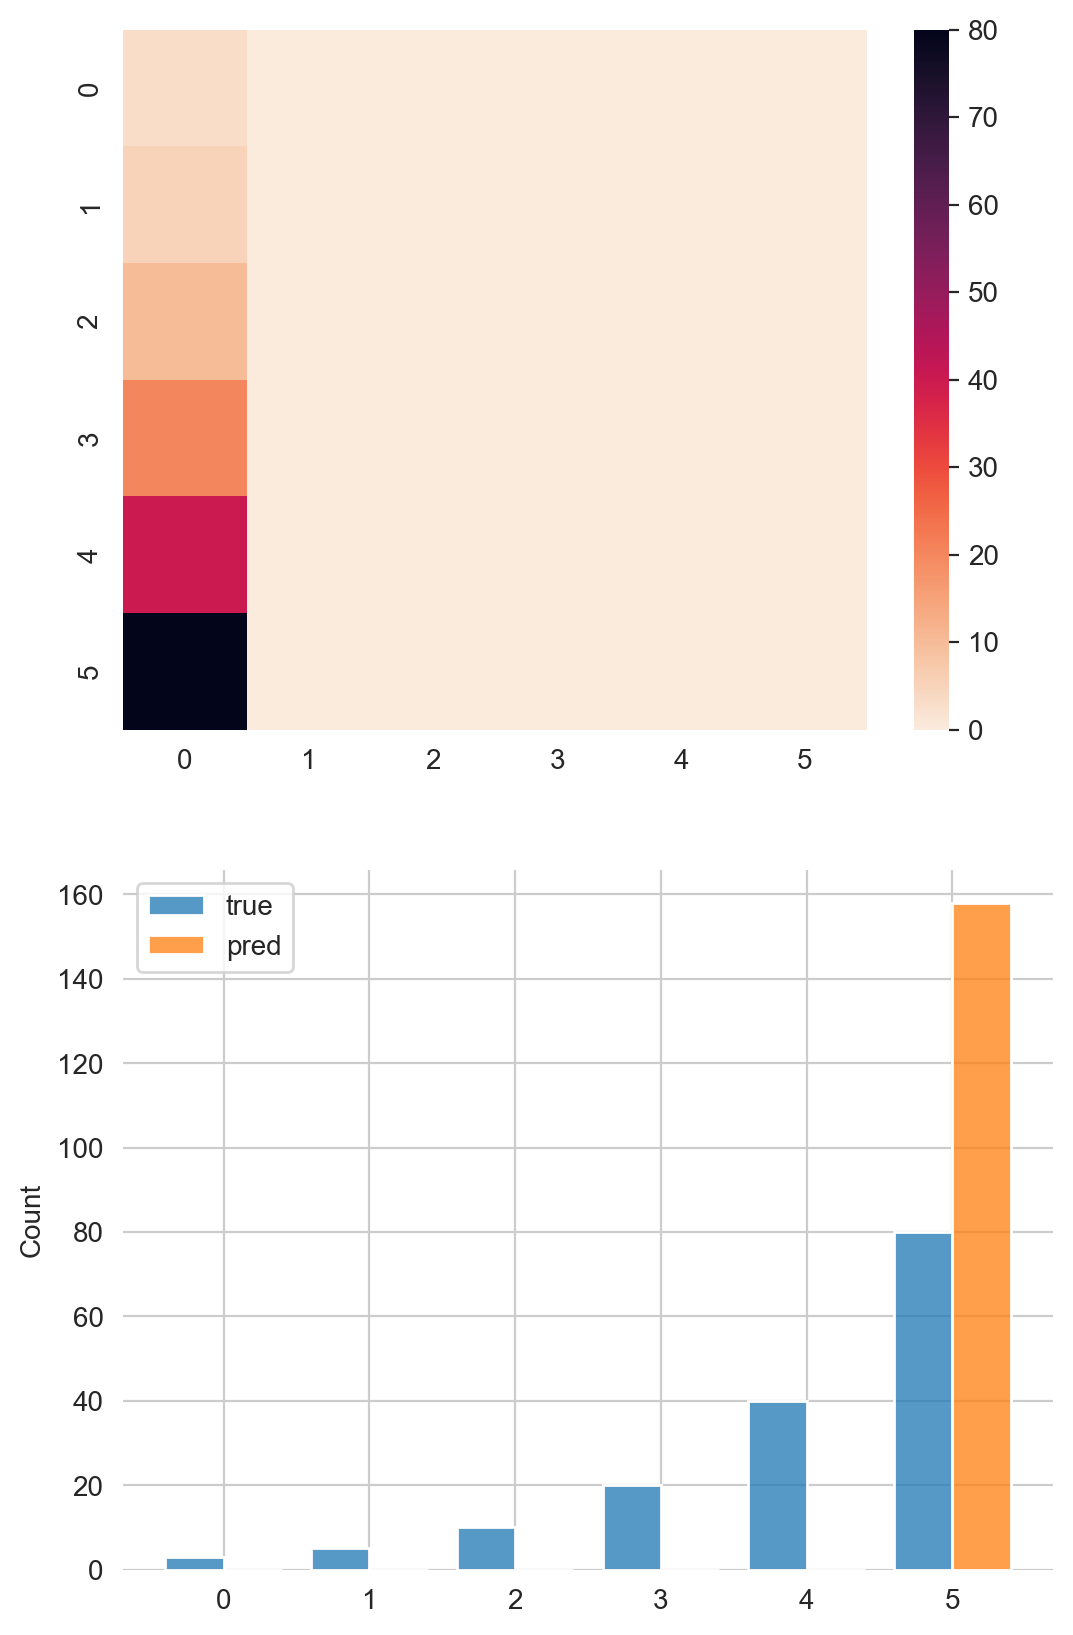

In [195]:
cm, cm_argmax, m_true, m_pred_matched = generate_matching(M_pred=1)
print("Matched modules:", cm_argmax)
fig, axes = plt.subplots(nrows=2, figsize=(6,10))
sns.heatmap(cm, cmap="rocket_r", ax=axes[0])
ax = sns.histplot(pd.DataFrame({"true": m_true, "pred": m_pred_matched}), multiple="dodge", ax=axes[1], binwidth=1, shrink=0.8, discrete=True)

### Varying noise level

Ground truth: 158 nodes and 6 modules


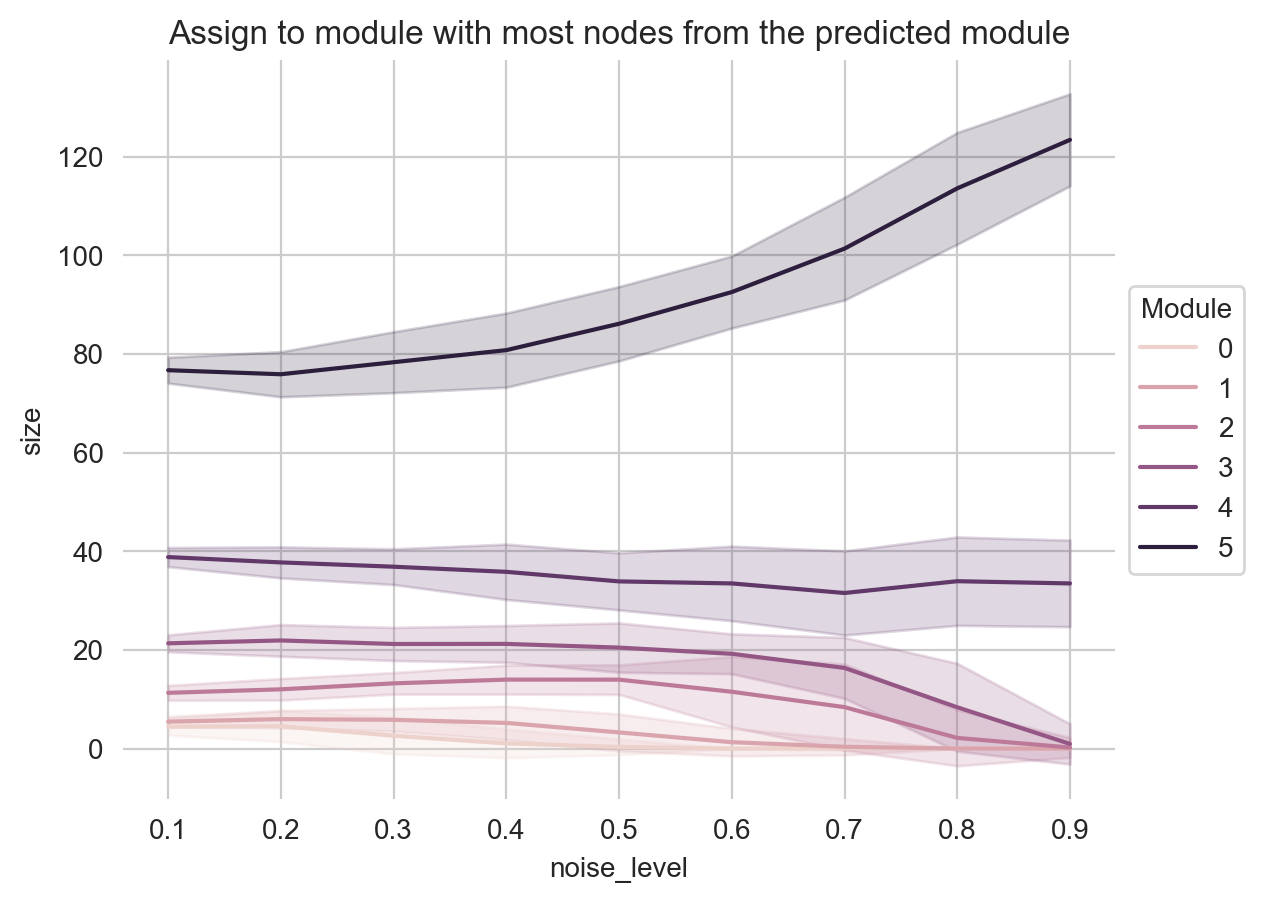

In [187]:
def run_module_sizes(normalize=False, num_trials=100, module_sizes=[3, 5, 10, 20, 40, 80], M_pred=10):
    data = []
    M_true = len(module_sizes)
    m_true = np.array([lbl for i, m in enumerate(module_sizes) for lbl in [i] * m])
    N = len(m_true)
    print(f"Ground truth: {N} nodes and {M_true} modules")

    module_sizes_pred = sample_multinomial(N, M_pred)
    m_rand = [lbl for i, m in enumerate(module_sizes_pred) for lbl in [i] * m]
    np.random.shuffle(m_rand)

    # p_true = 0.4
    for p_noise in np.arange(0.1, 1, 0.1):
        p_true = 1 - p_noise
        for n_trial in range(num_trials):
            ind_true = np.random.choice(N, int(p_true * N), replace=False)
            # Restrict to not create more modules than M_pred
            ind_true = ind_true[(m_true[ind_true] < M_pred).nonzero()[0]]
            m_pred = np.array(m_rand).copy()
            m_pred[ind_true] = m_true[ind_true]
            # reindex to consecutive labels
            m_unique = np.unique(m_pred)
            relabel = dict(zip(m_unique, np.arange(m_unique.shape[0])))
            m_pred = np.array([relabel[m] for m in m_pred])

            cm = confusion_matrix(m_true, m_pred)

            if normalize:
                norm = np.ones(cm.shape[0])
                for i, m in enumerate(module_sizes):
                    norm[i] = m
                cm = cm / np.outer(norm, np.ones(norm.shape))

            # relabel modules to match true labels
            cm_argmax = cm.argmax(axis=0)
            m_pred_matched = np.array([cm_argmax[i] for i in m_pred])

            modules, counts = np.unique(m_pred_matched, return_counts=True)
            m_count = dict(zip(modules, counts))
            
            for m in range(M_true):
                data.append([p_noise, n_trial, m, m_count[m] if m in m_count else 0])

    df = pd.DataFrame(data, columns=["noise_level", "trial", "module", "size"])
    return df

def visualize_module_sizes(df, title=""):
    sns.lineplot(data=df, x='noise_level', y='size', hue='module', errorbar="sd").set(title=title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Module")

df = run_module_sizes(M_pred=10)
visualize_module_sizes(df, title="Assign to module with most nodes from the predicted module")

With increasing randomization of predicted modules, the modules diverge in size.

Ground truth: 158 nodes and 6 modules


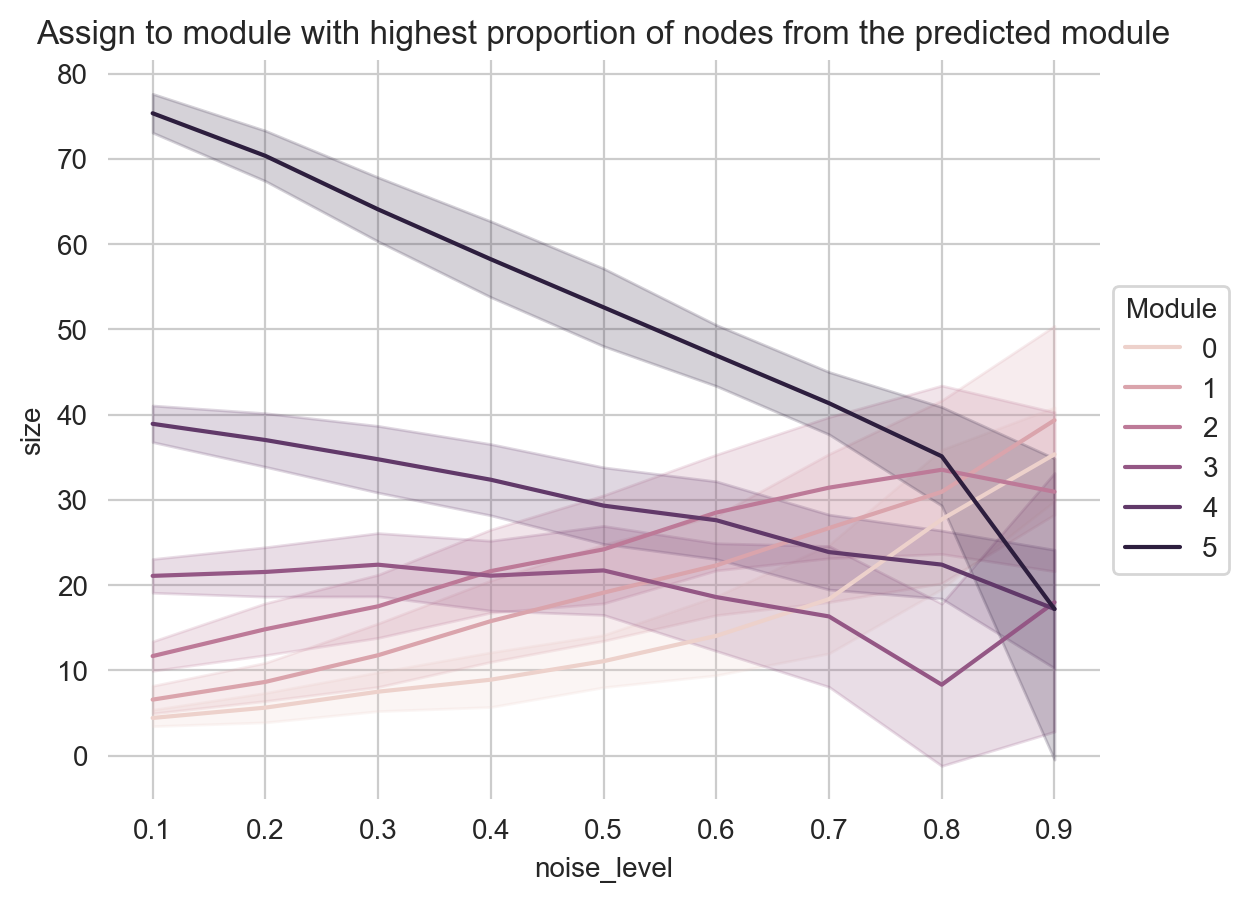

In [36]:
df = run_module_sizes(normalize=True)
visualize_module_sizes(df, title="Assign to module with highest proportion of nodes from the predicted module")

With normalized confusion matrix, the modules converge in size.

Ground truth: 159 nodes and 6 modules


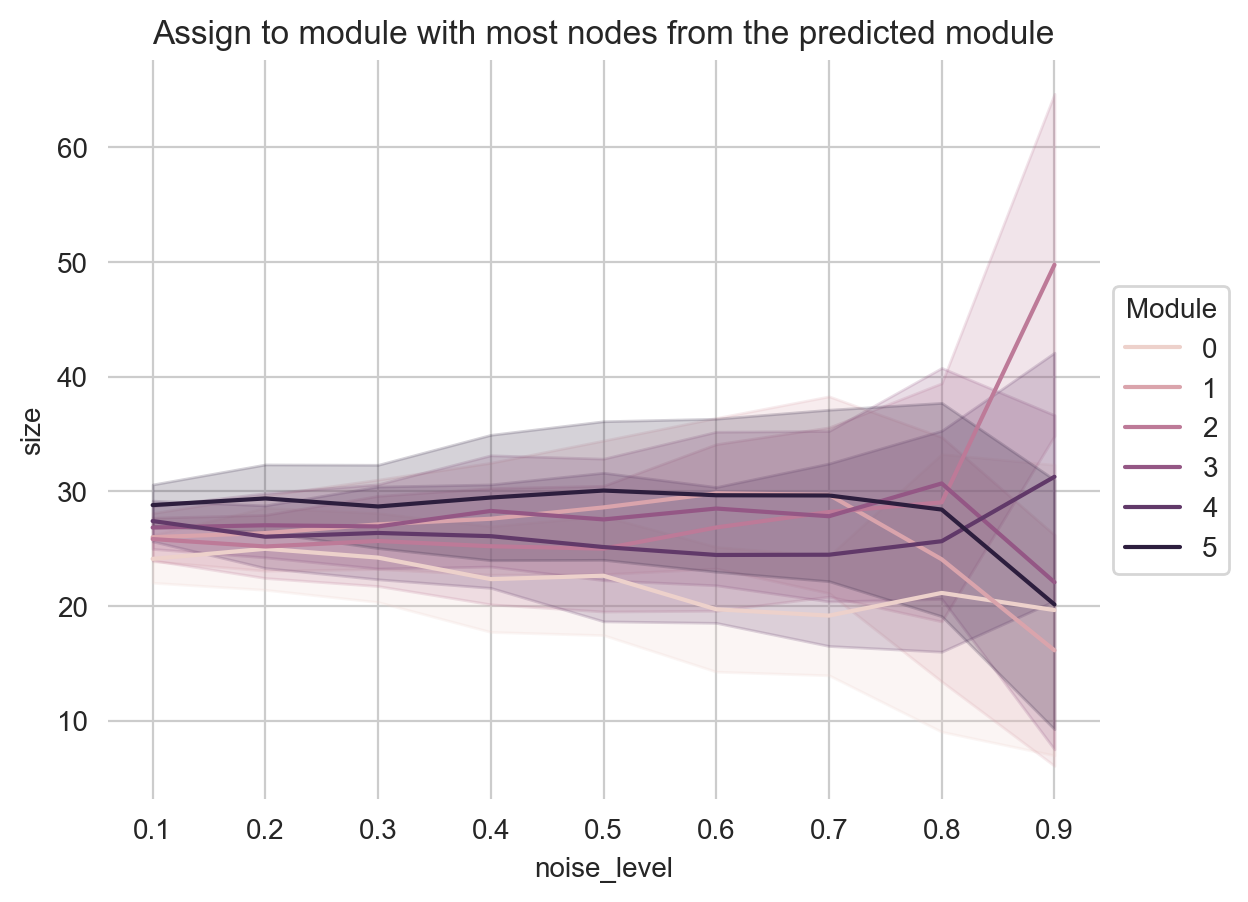

In [46]:
df = run_module_sizes(module_sizes=[24, 25, 26, 27, 28, 29], normalize=False)
visualize_module_sizes(df, title="Assign to module with most nodes from the predicted module")

With uniform initial module sizes, the diverging or converging patterns disappear.

## Conclusions

Matching partitions is a non-trivial problem, see for example https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.021003 for more information.